In [0]:
!pip install tensorflow-gpu==1.14 gpustat -qU
!pip install bayesian-optimization
!pip install -q tensorflow-hub
!pip install -q seaborn
!pip install bert-tensorflow

In [0]:
from google.colab import drive
drive.mount('/content/drive')

!git clone --depth 1 https://github.com/google-research/bert

In [0]:
# Import our dependencies
import tensorflow.compat.v1 as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
import pandas as pd
import tensorflow_hub as hub
import os
import re, sys, csv, pickle
from keras import backend as K
import tensorflow.keras.layers as layers
from keras.models import Model, load_model
from keras.engine import Layer
import numpy as np
from pathlib import Path
import codecs
from sklearn.model_selection import train_test_split
from tqdm import trange
from tqdm import tqdm
import bert
from bayes_opt import BayesianOptimization
from bert.tokenization import FullTokenizer
from tqdm import tqdm_notebook
from tensorflow.python.keras.backend import set_session
from sklearn.utils import shuffle

Using TensorFlow backend.


In [0]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
    When running eval/predict on the TPU, we need to pad the number of examples
    to be a multiple of the batch size, because the TPU requires a fixed batch
    size. The alternative is to drop the last batch, which is bad because it means
    the entire output data won't be generated.
    We use this class instead of `None` because treating `None` as padding
    battches could cause silent errors.
    """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module(bert_path):
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

def convert_test_text_to_examples(texts):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=None)
        )
    return InputExamples

In [0]:
#@title Notebook Parameters { run: "auto" }

#@markdown #### BERT module to Load
#@markdown * This will load a particular module from TF Hub

BERT_PATH   = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1" #@param {type:"string"}

#@markdown * `TUNE_CELLS` controls how many Transformer cells to finetune
#@markdown * Setting a value of `-1` means train entire BERT model
#@markdown * The authors recommend finetuning the entire BERT model

TUNE_CELLS = 1         #@param {type:"integer"}

#@markdown #### Dataset to Load

DATASET_URL = "https://deeplearning-mat.s3-ap-southeast-1.amazonaws.com/aclImdb_data.zip" #@param {type:"string"}
FILENAME    = "aclImdb_data.zip" #@param {type:"string"}

#@markdown #### Training Parameters

MIXED_PRECISION = True #@param ["True", "False"] {type:"raw"}
USE_XLA = True         #@param ["True", "False"] {type:"raw"}

MAX_SEQ_LEN = 256       #@param {type:"integer"}
VAL_SPLIT   = 0.3       #@param {type:"number"}


In [0]:
env_url = Path('/content/drive/My Drive/TP-final-SI')
file_url = env_url/'dataSetUserStoriesRecognition-tunend1.csv'

######LOADING FILE
csvfile = codecs.open(file_url, 'r', encoding='utf-8', errors='ignore')
reader = csv.DictReader(csvfile, delimiter=';')

data = []
labels = []

for row in reader:
  data.append(row['Resumen'].lower())
  labels.append(int(row['Class'].lower()))

#print(len(data))
#print(len(labels))
csvfile.close()

In [0]:
del csvfile
del reader

In [0]:
#####SPLIT TRAINING-VALIDATION
data_train, data_test, labels_train, labels_test = train_test_split(
    data, labels, test_size = 0.01,
    train_size = 0.99, shuffle = 1, random_state=42,  stratify=labels
)

In [0]:
train_text = data_train
train_text = [' '.join(t.split()[0:MAX_SEQ_LEN]) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = labels_train

In [0]:
config = tf.ConfigProto()

if USE_XLA:
    opt_level = tf.OptimizerOptions.ON_1
    tf.enable_resource_variables()
else:
    opt_level = tf.OptimizerOptions.OFF
    
config.graph_options.optimizer_options.global_jit_level = opt_level

config.graph_options.rewrite_options.auto_mixed_precision = MIXED_PRECISION

sess = tf.Session(config=config)
tf.keras.backend.set_session(sess)

sess = tf.keras.backend.get_session()

In [0]:
# Instantiate a BERT-specific tokenizer

tokenizer = create_tokenizer_from_hub_module(BERT_PATH)

# Convert data to InputExample format

train_examples = convert_text_to_examples(train_text, train_label)

feat = convert_examples_to_features(tokenizer,
                                    train_examples,
                                    max_seq_length=MAX_SEQ_LEN)

(train_input_ids,train_input_masks,train_segment_ids,train_labels) = feat

In [0]:
class BERT(tf.keras.layers.Layer):
    def __init__(self, finetune_cells, bert_path, debug=False, **kwargs):
        self.finetune_cells = finetune_cells
        self.trainable = True
        self.output_size = 768
        self.bert_path = bert_path
        self.debug = debug
        super(BERT, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(self.bert_path,
                               trainable=self.trainable,
                               name="{}_module".format(self.name))
        
        trainable_vars = self.bert.variables

        t_vs = [var for var in trainable_vars if not "/cls/" in var.name]

        trainable_vars = t_vs

        layer_name_list = []

        for i, var in enumerate(trainable_vars):
            if self.debug:
                var_shape = var.get_shape()
                var_params = 1
                for dim in var_shape:
                    var_params *= dim
                print(str(i), "-", "var:", var.name)
                print(" ", "shape:", var_shape , "param:", var_params)
                
            if "layer" in var.name:
                layer_name = var.name.split("/")[3]
                layer_name_list.append(layer_name)

        layer_names = list(set(layer_name_list))
        layer_names.sort()

        if self.debug:
            print(layer_names)

        if self.finetune_cells == -1:
            for var in trainable_vars:
                if "/pooler/" in var.name:
                    # ignore the undocumented pooling layer
                    # we will create our own
                    pass
                else:
                    self._trainable_weights.append(var)

        else:
            # Select how many layers to fine tune
            last_n_layers = len(layer_names) - self.finetune_cells

            for var in trainable_vars:
                if "layer" in var.name:
                    layer_name = var.name.split("/")[3]
                    layer_num = int(layer_name.split("_")[1])+1
                    if layer_num > last_n_layers:
                        # Add to trainable weights
                        self._trainable_weights.append(var)

            if self.debug:
                print("BERT module loaded with", len(layer_names),
                    "Transformer cells, training all cells >", last_n_layers)

        # Add non-trainable weights
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BERT, self).build(input_shape)

    def call(self, inputs):
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(input_ids=tf.cast(input_ids, dtype="int32"),
                           input_mask=tf.cast(input_mask, dtype="int32"),
                           segment_ids=tf.cast(segment_ids, dtype="int32"))
        result = self.bert(inputs=bert_inputs,
                           signature="tokens",
                           as_dict=True)["sequence_output"]
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

NameError: ignored

In [0]:
def initialize_vars():
  # initialize the session
  sess.run(tf.local_variables_initializer())
  sess.run(tf.global_variables_initializer())
  sess.run(tf.tables_initializer())
  tf.keras.backend.set_session(sess)

In [0]:
def build_model(dropout_rate = 0.15):
  # model inputs

    in_id      = layers.Input(shape=(MAX_SEQ_LEN,), name="input_ids")
    in_mask    = layers.Input(shape=(MAX_SEQ_LEN,), name="input_masks")
    in_segment = layers.Input(shape=(MAX_SEQ_LEN,), name="segment_ids")

    in_bert    = [in_id, in_mask, in_segment]

    # BERT layer

    l_bert = BERT(finetune_cells=TUNE_CELLS,
                  bert_path=BERT_PATH,
                  debug=False)(in_bert)

    # fully-connected layer and output

    l_pool = layers.GlobalMaxPooling1D()(l_bert)
    dropout = layers.Dropout(rate=dropout_rate)(l_pool)
    out_pred = layers.Dense(1, activation="sigmoid")(dropout)
    
    model = tf.keras.models.Model(inputs=in_bert, outputs=out_pred)

    """opt = tf.keras.optimizers.Adam(lr=learning_rate)
    if MIXED_PRECISION:
        opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)"""

    model.compile(loss="binary_crossentropy",
                  optimizer="SGD",
                  metrics=["accuracy"])

    #model.summary()
  
    initialize_vars()
    return model

In [0]:
def build_and_train_model(dropout_rate = 0.15,
                batch_s = 32, verbose = 0, save_model = False, epchs = 5, opti = True):  
    
    model = build_model(dropout_rate)

    history = model.fit([train_input_ids, train_input_masks, train_segment_ids], 
          train_labels, validation_split=VAL_SPLIT,
          workers=2, use_multiprocessing=True,
          epochs=epchs, batch_size=int(batch_s),
          verbose = verbose)

    if save_model:
      model.save(format(env_url/'rnn-bert-usrecog.h5'), "w+")  

    if opti:
      return history.history["val_acc"][-1]
    else:  
      return model,history;

In [0]:
def load_model():
  # Clear and load model
  model = None
  model = build_model()
  model.load_weights(format(env_url/'rnn-bert-usrecog.h5'))
  return model

In [0]:
def optimization():
    hypScope = {
        'dropout_rate': (0.1,0.3),
        'batch_s': (32,64)
    }
    bo = BayesianOptimization(build_and_train_model, hypScope)
    bo.maximize()
    print(bo.max)

In [0]:
#optimization()

In [0]:
model,history = build_and_train_model(batch_s=60, dropout_rate= 0.25, verbose=1, epchs = 7 , save_model = True, opti = False)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 5541 samples, validate on 2375 samples
Epoch 1/7
5541/5541 [==============================] - 243s 44ms/sample - loss: 0.3476 - acc: 0.8500 - val_loss: 0.1841 - val_acc: 0.9297
Epoch 2/7
5541/5541 [==============================] - 239s 43ms/sample - loss: 0.1761 - acc: 0.9338 - val_loss: 0.1317 - val_acc: 0.9549
Epoch 3/7
5541/5541 [==============================] - 230s 42ms/sample - loss: 0.1266 - acc: 0.9524 - val_loss: 0.1106 - val_acc: 0.9608
Epoch 4/7
5541/5541 [==============================] - 230s 41ms/sample - loss: 0.1081 - acc: 0.9635 - val_loss: 0.0998 - val_acc: 0.9655
Epoch 5/7
5541/5541 [==============================] - 230s 41ms/sample - loss: 0.0983 - acc: 0.9668 - val_loss: 0.1360 - val_acc: 0.9499
Epoch 6/7
5541/5541 [==============================] - 230s 42ms/sample - loss: 0.0927 - acc: 0.9673 - val_loss: 0.0949 - val_acc: 0.9697
Epoch 7/7
5541/5541 [==============================] - 230s 42ms/sample - loss: 0.0871 - acc: 0.9704 - val_loss: 0.0968 - va

In [0]:
import matplotlib.pyplot as plt

def plot_graphics(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show

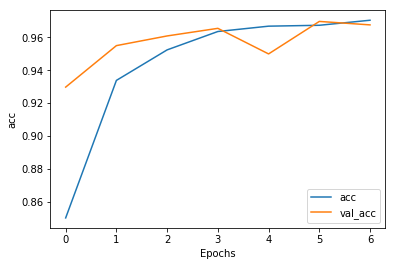

In [0]:
plot_graphics(history, 'acc')

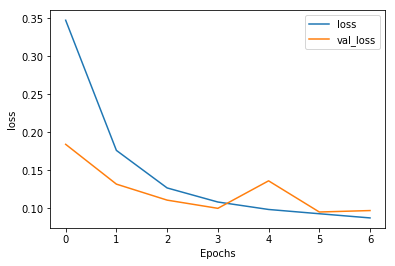

In [0]:
plot_graphics(history, 'loss')

In [0]:
if (env_url/'rnn-elmo-usrecog.h5').exists():
  model = load_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
test_texts = [
  "As a developer, I want to implement tests",
  "As a cat, i want",
  "As a cat, i want to be fed",
  "As a dog, i want to be washed",
  "As a tester, I want to implement tests so i can assure the softwares quality",
  "As a cat, I want to implement tests so i can assure the softwares quality",
  "as an administrator i want a gui admin for configuration options",
  "As a CONNECT administrator or security officer, I want to view audit events via the System Admninistration module so that I can monitor the audit logs and events",
  "A tester want to implement tests so he can assure the software quality",
  "An administrator will audit event via the system administration module",
  "An admnistrtor will audit event via the system administration module",
  "As a bug, I want reports so it can be check",
  "As a system, I want to be able in the all time",
  "An developer build should take less than 5 minutes",
  "As a developer the default build should take less than 5 minuts",
  "As a IA tester, I want to wrtie with ortografics errors to test efficiency",
  "I want a developer as much as good tester so I have a good team"
]

preprop_text = [' '.join(t.split()[0:MAX_SEQ_LEN]) for t in test_texts]
preprop_text = np.array(preprop_text, dtype=object)[:, np.newaxis]

test_examples = convert_test_text_to_examples(preprop_text)

feat = convert_examples_to_features(tokenizer,
                                    test_examples,
                                    max_seq_length=MAX_SEQ_LEN)

(test_input_ids,test_input_masks,test_segment_ids,test_labels) = feat

predicted = model.predict([test_input_ids, test_input_masks, test_segment_ids])

print("####Text to analize -> [probability of being an userstory]####") 
for text, prob in zip(test_texts, predicted): 
 print( text + "->" + format(prob))

Converting examples to features: 100%|██████████| 17/17 [00:00<00:00, 1539.16it/s]


####Text to analize -> [probability of being an userstory]####
As a developer, I want to implement tests->[0.99354815]
As a cat, i want->[0.00597593]
As a cat, i want to be fed->[0.13646677]
As a dog, i want to be washed->[0.01884067]
As a tester, I want to implement tests so i can assure the softwares quality->[0.99105304]
As a cat, I want to implement tests so i can assure the softwares quality->[0.97498393]
as an administrator i want a gui admin for configuration options->[0.86234677]
As a CONNECT administrator or security officer, I want to view audit events via the System Admninistration module so that I can monitor the audit logs and events->[0.9639759]
A tester want to implement tests so he can assure the software quality->[0.00122225]
An administrator will audit event via the system administration module->[0.00096086]
An admnistrtor will audit event via the system administration module->[0.00213298]
As a bug, I want reports so it can be check->[0.7283269]
As a system, I want to